In [1]:
verbose = True
very_verbose = False
eval_ML = True
eval_community = False
eval_spectral = False
eval_all = False

import os
for dirname, _, filenames in os.walk('/kaggle/input/train-test-dataset-ton'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/train-test-dataset-ton/Train_Test_Network_ton.csv


In [2]:
print("working directory:") 
!pwd

working directory:
/kaggle/working


In [3]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

df_original_data = pd.read_csv("/kaggle/input/train-test-dataset-ton/Train_Test_Network_ton.csv")
if verbose:
    print(df_original_data.shape)

(461043, 45)


<div class="alert alert-block alert-info" style="font-size:25px; font-family:verdana; color:white;background-color:green;">
    <a id="exploratory-data-analysis"></a>
    📌 Second: Exploratory Data Analysis 
</div>

In [4]:
if verbose :
    print(list(df_original_data.columns))
if very_verbose :
    print(df_original_data.dtypes)

['ts', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'label', 'type']


In [5]:
binary_label = 'label'
# attack_cat_label = 'category'
attack_label = 'type'

binary_label_count = df_original_data[binary_label].value_counts()
# attack_cat_label_count = df_original_data[attack_cat_label].value_counts()
attack_label_count = df_original_data[attack_label].value_counts()

attacks = df_original_data[binary_label].unique()
categories = df_original_data[attack_label].unique()
# subcategories = df_original_data[attack_label].unique()

if verbose :
    print(attacks)
    print(categories)
    # print(subcategories)

[0 1]
['normal' 'scanning' 'dos' 'injection' 'ddos' 'password' 'xss'
 'ransomware' 'backdoor' 'mitm']


label
0    300000
1    161043
Name: count, dtype: int64 

type
normal        300000
scanning       20000
dos            20000
injection      20000
ddos           20000
password       20000
xss            20000
ransomware     20000
backdoor       20000
mitm            1043
Name: count, dtype: int64 



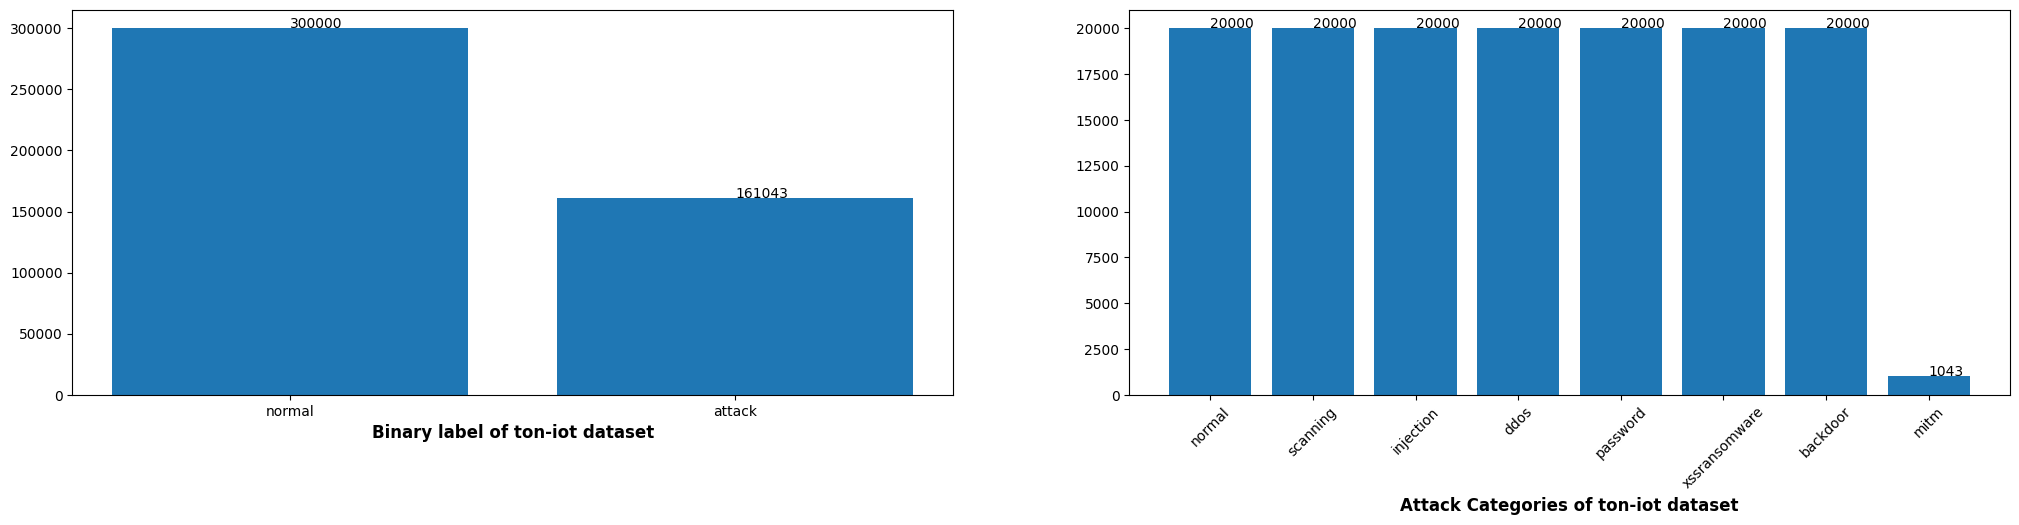

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
        
#get the count of the attack labels and attack categories 
binary_label_count = df_original_data[binary_label].value_counts()
attack_cat_label_count = df_original_data[attack_label].value_counts()

#print labels and attack categories/subcategories
print(binary_label_count,'\n')
print(attack_cat_label_count,'\n')

plt.figure(figsize=(25, 5))

#plot binary label
axs = plt.subplot(1, 2, 1)
x = ['normal','attack']
y = [binary_label_count[0],binary_label_count[1]]
plt.bar(x, y)
plt.xlabel('Binary label of ton-iot dataset', fontweight='bold', color = 'black',
           fontsize='12', horizontalalignment='center')
addlabels(x, y)


#plot attack categories
axs = plt.subplot(1, 2, 2)
x = ['normal','scanning','injection','ddos','password','xss'
 'ransomware','backdoor','mitm']
y = [attack_cat_label_count[1],attack_cat_label_count[2]
    ,attack_cat_label_count[4],attack_cat_label_count[5]
    ,attack_cat_label_count[6],attack_cat_label_count[7]
    ,attack_cat_label_count[8],attack_cat_label_count[9]]
plt.bar(x,y)
plt.xticks(rotation=45) 
plt.xlabel('Attack Categories of ton-iot dataset', fontweight='bold',
           color = 'black',
           fontsize='12', horizontalalignment='center')
addlabels(x, y)


plt.show()

<div class="alert alert-block alert-warning" style="font-size:14px; font-family:verdana; color:black;background-color:light-gray;">
    <a id="Files-directory"></a>
    🔵➖😈➖🔵 Visualize interactions (graphs)
</div>


In [7]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import igraph as ig

def extract_graph(dataset, graph_type, label, src_addr, daddr, sport=0, dst_port=0, smac=0, dst_mac=0):

    """ Extract the graph attack according to the type we need to show

        Parameters
        ----------
        dataset: dataset, graph_type: type of graph we need to show (ip, ip + proto, or ip + mac),
        label: label of the attack, src_addr: source ip, daddr: destination ip, sport: source port,
        dst_port: destination port, smac: source mac, dst_mac: destination mac

        Returns
        -------
        graph of nodes and edges , attack_list for the type of attack found on the edge between two nodes (ip sources) ,
         attack_labels for the label of the attacks in the dataset
        """

    format_supported = True
    if graph_type == 'ip':
        dataset['source_node'] = dataset[src_addr]
        dataset['dst_node'] = dataset[daddr]
    else:
        if graph_type == 'ip_proto':
            comp_field1 = sport
            comp_field2 = dst_port
        elif graph_type == 'mac':
            comp_field1 = smac
            comp_field2 = dst_mac
        else:
            format_supported = False
        if format_supported:
            dataset['source_node'] = dataset[src_addr] + ':' + dataset[comp_field1].astype(str)
            dataset['dst_node'] = dataset[daddr] + ':' + dataset[comp_field2].astype(str)
        else:
            print('Graph type not supported :' + graph_type)

    dataset['edge'] = dataset['source_node'] + ':' + dataset['dst_node']
    dataset['edge_label'] = dataset[sport].astype(str) + ':' + dataset[dst_port].astype(str) + ':' + dataset[label].astype(str)
    graph = nx.Graph()
    # pos = nx.layout.spring_layout(graph)
    sip_list = dataset['source_node']
    dip_list = dataset['dst_node']
    ip_list = [*sip_list, *dip_list]

    graph.add_nodes_from(ip_list)
    attack_labels = dataset[label]
    edge_label_list = dataset['edge_label']

    attack_list = []

    for u, v, d in zip(sip_list, dip_list, edge_label_list):
        # graph.add_edge(u, v, label=d)
        label = d.split(':')[2]
        colors = {
            0: 'blue',
            1: 'red',
        }
        color = colors[int(label[0])]
        graph.add_edge(u, v, label=d, color=color)

    for k, v, d in graph.edges(data=True):
        attack_list.append(d['label'].split(':')[2])

    return graph, attack_list, attack_labels

def show_graph(graph):

    """ Show the graph we extracted as nodes and edges in networkx

        Parameters
        ----------
        graph : graph with nodes and edges

        Returns
        -------
        display a graph with nodes and edges using networkx
        """
    

    if(graph.number_of_nodes() > 3000):
        sampled_edges = random.sample(graph.eg, 3000)
        sampled_graph = graph.subgraph(sampled_nodes)
        plt.figure(figsize=(200, 80))
        pos = nx.layout.spring_layout(sampled_graph)
        colors = [sampled_graph[u][v]['color'] for u, v in sampled_graph.edges()]
        nx.draw_networkx(sampled_graph,edge_color=colors,pos = pos)
        plt.show()
    else:
        plt.figure(figsize=(200, 80))
        pos = nx.layout.spring_layout(graph)
        colors = [graph[u][v]['color'] for u, v in graph.edges()]
        nx.draw_networkx(graph,edge_color=colors,pos = pos)
        plt.show()
        
def show_graph2(graph):
    
    if(graph.number_of_nodes() > 3000):
        sampled_edges = random.sample(graph.edges, 3000)
        sampled_graph = graph.edge_subgraph(sampled_edges)
        G=ig.Graph.from_networkx(sampled_graph)
        N = sampled_graph.number_of_nodes()
    else:
        G=ig.Graph.from_networkx(graph)
        N = graph.number_of_nodes()
    E=[e.tuple for e in G.es]# list of edges
    layt=G.layout('fr') 
    type(layt)
    
    Xn=[layt[k][0] for k in range(N)]
    Yn=[layt[k][1] for k in range(N)]
    Xe=[]
    Ye=[]
    for e in E:
        Xe+=[layt[e[0]][0],layt[e[1]][0], None]
        Ye+=[layt[e[0]][1],layt[e[1]][1], None]

    trace1=go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line= dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   )
    trace2=go.Scatter(x=Xn,
                   y=Yn,
                   mode='markers',
                   name='ntw',
                   marker=dict(symbol='circle-dot',
                                            size=5,
                                            color='#6959CD',
                                            line=dict(color='rgb(50,50,50)', width=0.5)
                                            ),
                   hoverinfo='text'
                   )
    
    fig = go.Figure(data=[trace1, trace2],
             layout=go.Layout(
                title='<br>Graph of the network',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    fig.show()

In [8]:
from time import gmtime, strftime
print (strftime("%Y-%m-%d %H:%M:%S", gmtime()))
graph, attack_list, attack_labels = extract_graph(df_original_data, 'ip', 'label', 'src_ip', 'dst_ip',
                                                  'src_port', 'dst_port')
print (strftime("%Y-%m-%d %H:%M:%S", gmtime()))
show_graph2(graph)
print (strftime("%Y-%m-%d %H:%M:%S", gmtime()))

2025-01-28 21:15:42
2025-01-28 21:15:44


2025-01-28 21:15:45


<div class="alert alert-block alert-warning" style="font-size:14px; font-family:verdana; color:black;background-color:light-gray;">
    <a id="Files-directory"></a>
    🔀 Transform categories to codes
</div>


In [9]:
df_scores = pd.DataFrame(columns=['attack_type', 'attack_label', 'approach_name', 'classifier', 'f1_score', 'balanced_accuracy', 'MCC', 'Precision', 'Recall', 'order'])
print(type(df_scores))


<class 'pandas.core.frame.DataFrame'>


<div class="alert alert-block alert-info" style="font-size:50px; font-family:verdana; color:white;background-color:green;">
    <a id="approaches"></a>
    📌 Approaches
</div>


In [10]:
map_dict= {
    'normal': 0,
    'scanning': 1,
    'dos': 2,
    'ddos': 3,
    'ransomware': 4,
    'injection': 5,
    'password': 6,
    'xss': 7,
    'backdoor':8,
    'mitm':9
    
}

In [11]:
import numpy as np
import math
from scipy.misc import derivative
import statistics

def metric1(spec, num_components):
    M1 = math.exp(1 / num_components) / math.exp(1)
    return M1
    
def metric2(spec, num_components):
    algebraic_conn = spec[num_components:num_components + num_components]
    if len(algebraic_conn) < 1:
        return 0
    mean = statistics.mean(algebraic_conn)
    return (np.exp(mean) - 1.0)

def metric3(spec, num_components):
    max_deg = spec[len(spec) - num_components:len(spec)]
    mean = statistics.mean(max_deg)
    return mean

def metric4(spec):
    x = np.arange(len(spec))
    dx = np.diff(x)
    count = 0
    for k in range(len(dx) - 1):
        if dx[k] > math.pow(10, -12):
            count += 1
    return count
    
def metric5(S):
    return sum(S)

In [12]:
import networkx as nx

def extract_graph(tw, src, dst, ts, edge_weight):
    g = nx.Graph()
    
    for _, row in tw.iterrows():
        src_ip = row[src]
        dst_ip = row[dst]
        weight = row[edge_weight]

        if g.has_edge(src_ip, dst_ip):
            g[src_ip][dst_ip]['weight'] += weight
        elif g.has_edge(dst_ip, src_ip):
            g[dst_ip][src_ip]['weight'] += weight
        else:
            g.add_edge(src_ip, dst_ip, weight=weight)
    l = nx.laplacian_matrix(g, weight='weight').todense()
    # ev = np.linalg.eigvalsh(l)
    ev, evecs = np.linalg.eigh(l)
    return g, l, np.sort(ev), evecs

def draw_graph(g):
    pos = nx.spring_layout(g)
    nx.draw_networkx(graph, pos=pos, with_labels=True, node_color='lightblue')
    plt.title("Undirected Graph")
    plt.axis('off')
    plt.show()
    
def extract_vector_metrics(spectrum):
    # extract here
    print()
    
def plot_two_graphs(G1, G2, ts1, ts2, ev1, ev2):
    print(ts1)
    pos = nx.spring_layout(G1)
    nx.draw(G1,pos, with_labels=True, node_color='lightblue', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G1, 'weight')
    nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
    plt.show()
    
    x = range(len(ev1))
    y = ev1

    plt.plot(x, y)
    plt.xlabel('index')
    plt.ylabel('eigenvalues')
    plt.title('spectrum')
    plt.show()
    
    print(ts2)
    pos = nx.spring_layout(G2)
    nx.draw(G2,pos, with_labels=True, node_color='lightblue', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels)
    plt.show()
    
    x = range(len(ev2))
    y = ev2

    plt.plot(x, y)
    plt.xlabel('index')
    plt.ylabel('eigenvalues')
    plt.title('spectrum')
    plt.show()

def extract_Lprime(eigenvalues, eigenvectors, laplacian_matrix):
    fiedler_vector = eigenvectors[:, 1] if len(eigenvalues) > 1 else eigenvectors[:, 0]
    partition_fiedler = {node: 0 if val < 0 else 1 for node, val in zip(graph.nodes(), fiedler_vector)}

    # Partition using largest eigenvector
    largest_eigenvector = eigenvectors[:, -1]
    partition_largest_ev = {node: 0 if val < 0 else 1 for node, val in zip(graph.nodes(), largest_eigenvector)}
    group_a_largest_ev = [node for node, label in partition_largest_ev.items() if label == 0]
    group_b_largest_ev = [node for node, label in partition_largest_ev.items() if label == 1]

    # Extract the submatrix A'
    L_prime = laplacian_matrix[:len(group_a_largest_ev), -len(group_b_largest_ev):]

    return L_prime

In [13]:
include_m1 = 1
include_m2 = 1
include_m3 = 1
include_m4 = 1
include_m5 = 1

In [14]:
df_original_data_tmp = df_original_data.copy() 

df_original_data_tmp['duration'].replace(0, np.nan, inplace=True)
df_original_data_tmp['duration'].fillna(df_original_data_tmp['duration'].median(), inplace=True)
df_original_data_tmp['pkts'] = df_original_data_tmp['src_pkts'] + df_original_data_tmp['dst_pkts']
df_original_data_tmp['bytes'] = df_original_data_tmp['src_bytes'] + df_original_data_tmp['dst_bytes']
df_original_data_tmp['rate'] = df_original_data_tmp['pkts'] / df_original_data_tmp['duration']

df_original_data_tmp['weight'] = 1
df_to_sample = df_original_data_tmp.copy()
print(df_to_sample['type'].unique())
df_to_sample['type'] = df_to_sample['type'].replace(map_dict)
# df_to_sample = df_to_sample[(df_to_sample['category'] == 'Normal') | (df_to_sample['subcategory'] == 'Service_Scan')]
# print(df_to_sample['category'].unique())

if verbose:
    print(df_original_data_tmp.shape)

df_to_sample['datetime'] = pd.to_datetime(df_to_sample['ts'], unit='s')
# Extract columns
df_timeseries = df_to_sample[['ts', 'datetime', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'pkts', 'bytes', 'rate', 'src_pkts', 'dst_pkts', 'src_bytes', 'dst_bytes',
                             'label', 'type', 'weight','duration']]
df_timeseries = df_timeseries.sort_values(by=['ts'])
# print(df[['stime', 'datetime', 'saddr', 'daddr','pkts', 'attack', 'weight']].head(50))

# Group by columns
df_timeseries = df_timeseries.groupby(['ts', 'datetime', 'src_ip', 'dst_ip'], as_index=False).agg({
    'src_pkts': 'sum', 'dst_pkts': 'sum', 'label': 'first', 'type':'first', 'pkts': 'sum', 'bytes': 'sum', 'rate': 'sum',
    'src_bytes': 'sum', 'dst_bytes': 'sum', 'duration':'mean', 'weight':'sum'})

print(df_timeseries.head(20))

if verbose:
    print(df_timeseries.shape)

df_timeseries_tmp = df_timeseries.copy()

['normal' 'scanning' 'dos' 'injection' 'ddos' 'password' 'xss'
 'ransomware' 'backdoor' 'mitm']
(461043, 53)
            ts            datetime         src_ip          dst_ip  src_pkts  \
0   1554198358 2019-04-02 09:45:58   192.168.1.79   192.168.1.255         1   
1   1554198358 2019-04-02 09:45:58    3.122.49.24   192.168.1.152    252181   
2   1554198359 2019-04-02 09:45:59  192.168.1.152   192.168.1.152         0   
3   1554198362 2019-04-02 09:46:02  192.168.1.152   192.168.1.190         0   
4   1554198364 2019-04-02 09:46:04  192.168.1.152   192.168.1.152         0   
5   1554198364 2019-04-02 09:46:04   192.168.1.79   192.168.1.255         1   
6   1554198369 2019-04-02 09:46:09  192.168.1.152   192.168.1.152         0   
7   1554198370 2019-04-02 09:46:10   192.168.1.79   192.168.1.255         1   
8   1554198374 2019-04-02 09:46:14  192.168.1.152   192.168.1.152         0   
9   1554198376 2019-04-02 09:46:16   192.168.1.79   192.168.1.255         1   
10  1554198377 2019-04

In [15]:
 def get_first_value(series):
    return series.iloc[0]

In [16]:
import numpy as np
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler

def safe_svd(matrix, num_components=None, method='auto'):
    """
    Perform SVD safely while handling potential numerical issues.

    Parameters:
    - matrix (numpy.ndarray): Input matrix to decompose.
    - num_components (int): Number of singular values/vectors to compute.
    - method (str): 'auto' to choose best method, 'scipy' for sparse SVD, 'sklearn' for randomized SVD.

    Returns:
    - U (numpy.ndarray): Left singular vectors
    - S (numpy.ndarray): Singular values
    - Vh (numpy.ndarray): Right singular vectors (transposed)
    """

    # Step 1: Handle NaN or Inf values
    if np.isnan(matrix).any() or np.isinf(matrix).any():
        # print("Handling NaN/Inf values...")
        matrix = np.nan_to_num(matrix, nan=0.0, posinf=np.max(matrix[np.isfinite(matrix)]), neginf=np.min(matrix[np.isfinite(matrix)]))

    # Step 2: Normalize values to prevent large numbers
    scaler = MinMaxScaler()
    matrix = scaler.fit_transform(matrix)

    # Step 3: Add small regularization to avoid singularity issues
    matrix += np.eye(matrix.shape[0]) * 1e-10

    # Step 4: Choose the number of components if not specified
    if num_components is None:
        num_components = min(matrix.shape) - 1

    # Step 5: Perform SVD with error handling
    try:
        if method == 'auto':
            # Use SciPy for large sparse matrices, otherwise sklearn
            if matrix.shape[0] > 5000:
                method = 'scipy'
            else:
                method = 'sklearn'

        if method == 'scipy':
            # print("Using SciPy's SVD...")
            U, S, Vh = svds(matrix, k=num_components)
        elif method == 'sklearn':
            # print("Using Sklearn's randomized SVD...")
            U, S, Vh = randomized_svd(matrix, n_components=num_components, random_state=42)
        else:
            # print("Using NumPy's standard SVD...")
            U, S, Vh = np.linalg.svd(matrix, full_matrices=False)

        return U, S, Vh

    except np.linalg.LinAlgError as e:
        # print("SVD did not converge, retrying with a different method...")
        return svds(matrix, k=num_components)

In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


df = df_timeseries_tmp.copy()
df_topredict = pd.DataFrame()

df['next_stime'] = df['ts'] + 30
df['next_datetime'] = pd.to_datetime(df['next_stime'], unit='s')

count_one_min_windows = 0

for index, row in df.iterrows():
    attack_label =0
    current_timestamp = row['ts']
    next_timestamp = row['next_stime']
    mask = (df['ts'] <= next_timestamp) & (df['ts'] >= current_timestamp)
    time_window = df[mask]
    unique_time_window = time_window.iloc[:, 0].unique()
    
    if len(unique_time_window) >= 10:
        
        # print(unique_time_window)
        count_one_min_windows += 1
        
        # ts1
        ts1 = unique_time_window[len(unique_time_window) - int(len(unique_time_window)/2)]
        mask = (time_window['ts'] <= ts1) & (time_window['ts'] >= current_timestamp)
        sub_time_window = time_window[mask]
        
        g1_pkts, l1_pkts, ev1_pkts, evec1_pkts = extract_graph(sub_time_window, 'src_ip', 'dst_ip', ts1, 'pkts')
        l1_prime_pkts = extract_Lprime(ev1_pkts, evec1_pkts, l1_pkts)
        # Perform Singular Value Decomposition (SVD) on the Laplacian matrix
        U_pkts, S_pkts, Vh_pkts = np.linalg.svd(l1_prime_pkts, full_matrices=False)
        num_components_pkts = nx.number_connected_components(g1_pkts)
        
        t1_m1_pkts = metric1(ev1_pkts, num_components_pkts)
        t1_m2_pkts = metric2(ev1_pkts, num_components_pkts)
        t1_m3_pkts = metric3(ev1_pkts, num_components_pkts)
        t1_m4_pkts = metric4(ev1_pkts[1:])
        t1_m5_pkts = metric5(S_pkts)
        
        g1_bytes, l1_bytes, ev1_bytes, evec1_bytes = extract_graph(sub_time_window, 'src_ip', 'dst_ip', ts1, 'bytes')
        num_components_bytes = nx.number_connected_components(g1_bytes)
        l1_prime_bytes = extract_Lprime(ev1_bytes, evec1_bytes, l1_bytes)
        # Perform Singular Value Decomposition (SVD) on the Laplacian matrix
        U_bytes, S_bytes, Vh_bytes = np.linalg.svd(l1_prime_bytes, full_matrices=False)
        
        t1_m1_bytes = metric1(ev1_bytes, num_components_bytes)
        t1_m2_bytes = metric2(ev1_bytes, num_components_bytes)
        t1_m3_bytes = metric3(ev1_bytes, num_components_bytes)
        t1_m4_bytes = metric4(ev1_bytes[1:])
        t1_m5_bytes = metric5(S_bytes)
        
        g1_rate, l1_rate, ev1_rate, evec1_rate = extract_graph(sub_time_window, 'src_ip', 'dst_ip', ts1, 'rate')
        num_components_rate = nx.number_connected_components(g1_rate)
        l1_prime_rate = extract_Lprime(ev1_rate, evec1_rate, l1_rate)
        # Perform Singular Value Decomposition (SVD) on the Laplacian matrix
        U_rate, S_rate, Vh_rate = np.linalg.svd(l1_prime_rate, full_matrices=False)
        
        t1_m1_rate = metric1(ev1_rate, num_components_rate)
        t1_m2_rate = metric2(ev1_rate, num_components_rate)
        t1_m3_rate = metric3(ev1_rate, num_components_rate)
        t1_m4_rate = metric4(ev1_rate[1:])
        t1_m5_rate = metric5(S_rate)
        
        # ts2
        ts2 = unique_time_window[len(unique_time_window) - 1]
        mask = (time_window['ts'] <= ts2) & (time_window['ts'] >= current_timestamp)
        sub_time_window = time_window[mask]
        
        if (sub_time_window.tail(1)['type'] != 0).any():
            attack_label = sub_time_window.tail(1)['type'].item()
            
        
        g2_pkts, l2_pkts, ev2_pkts, evec2_pkts = extract_graph(sub_time_window, 'src_ip', 'dst_ip', ts2, 'pkts')
        num_components_pkts = nx.number_connected_components(g2_pkts)

        l2_prime_pkts = extract_Lprime(ev2_pkts, evec2_pkts, l2_pkts)
        # Perform Singular Value Decomposition (SVD) on the Laplacian matrix
        U2_pkts, S2_pkts, Vh2_pkts = np.linalg.svd(l2_prime_pkts, full_matrices=False)# safe_svd(l2_prime_pkts)
        
        t2_m1_pkts = metric1(ev1_pkts, num_components_pkts)
        t2_m2_pkts = metric2(ev1_pkts, num_components_pkts)
        t2_m3_pkts = metric3(ev1_pkts, num_components_pkts)
        t2_m4_pkts = metric4(ev1_pkts[1:])
        t2_m5_pkts = metric5(S2_pkts)
        
        g2_bytes, l2_bytes, ev2_bytes, evec2_bytes = extract_graph(sub_time_window, 'src_ip', 'dst_ip', ts2, 'bytes')
        num_components_bytes = nx.number_connected_components(g2_bytes)
        l2_prime_bytes = extract_Lprime(ev2_bytes, evec2_bytes, l2_bytes)
        # Perform Singular Value Decomposition (SVD) on the Laplacian matrix
        U2_bytes, S2_bytes, Vh2_bytes = np.linalg.svd(l2_prime_bytes, full_matrices=False)
        
        t2_m1_bytes = metric1(ev2_bytes, num_components_bytes)
        t2_m2_bytes = metric2(ev2_bytes, num_components_bytes)
        t2_m3_bytes = metric3(ev2_bytes, num_components_bytes)
        t2_m4_bytes = metric4(ev2_bytes[1:])
        t2_m5_bytes = metric5(S2_bytes)
        
        g2_rate, l2_rate, ev2_rate, evec2_rate = extract_graph(sub_time_window, 'src_ip', 'dst_ip', ts2, 'rate')
        num_components_rate = nx.number_connected_components(g2_rate)
        l2_prime_rate = extract_Lprime(ev2_rate, evec2_rate, l2_rate)
        # Perform Singular Value Decomposition (SVD) on the Laplacian matrix
        U2_rate, S2_rate, Vh2_rate = np.linalg.svd(l2_prime_rate, full_matrices=False)
        
        t2_m1_rate = metric1(ev2_rate, num_components_rate)
        t2_m2_rate = metric2(ev2_rate, num_components_rate)
        t2_m3_rate = metric3(ev2_rate, num_components_rate)
        t2_m4_rate = metric4(ev2_rate[1:])
        t2_m5_rate = metric5(S2_rate)
        
        d = {}
        if include_m1:
            d['t1_m1_pkts'] = [t1_m1_pkts]
            d['t2_m1_pkts'] = [t2_m1_pkts]
            d['t1_m1_bytes'] = [t1_m1_bytes]
            d['t2_m1_bytes'] = [t2_m1_bytes]
            d['t1_m1_rate'] = [t1_m1_rate]
            d['t2_m1_rate'] = [t2_m1_rate]
            
        if include_m2:
            d['t1_m2_pkts'] = [t1_m2_pkts]
            d['t2_m2_pkts'] = [t2_m2_pkts]
            d['t1_m2_bytes'] = [t1_m2_bytes]
            d['t2_m2_bytes'] = [t2_m2_bytes]
            d['t1_m2_rate'] = [t1_m2_rate]
            d['t2_m2_rate'] = [t2_m2_rate]
            
        if include_m3:
            d['t1_m3_pkts'] = [t1_m3_pkts]
            d['t2_m3_pkts'] = [t2_m3_pkts]
            d['t1_m3_bytes'] = [t1_m3_bytes]
            d['t2_m3_bytes'] = [t2_m3_bytes]
            d['t1_m3_rate'] = [t1_m3_rate]
            d['t2_m3_rate'] = [t2_m3_rate]
            
        if include_m4:
            d['t1_m4_pkts'] = [t1_m4_pkts]
            d['t2_m4_pkts'] = [t2_m4_pkts]
            d['t1_m4_bytes'] = [t1_m4_bytes]
            d['t2_m4_bytes'] = [t2_m4_bytes]
            d['t1_m4_rate'] = [t1_m4_rate]
            d['t2_m4_rate'] = [t2_m4_rate]
            
        if include_m5:
            d['t1_m5_pkts'] = [t1_m5_pkts]
            d['t2_m5_pkts'] = [t2_m5_pkts]
            d['t1_m5_bytes'] = [t1_m5_bytes]
            d['t2_m5_bytes'] = [t2_m5_bytes]
            d['t1_m5_rate'] = [t1_m5_rate]
            d['t2_m5_rate'] = [t2_m5_rate]
            
        agg_series = sub_time_window.agg({
            'pkts': 'sum', 'bytes': 'sum', 'type': get_first_value, 
            'rate': 'mean', 'weight':'sum'
        })

        # Convert the series to a single-row DataFrame
        agg_row = agg_series.to_frame().transpose()
        # print(attack_label)
        agg_row['type'] = attack_label
        
        if include_m1:
            agg_row['t1_m1_pkts'] = [t1_m1_pkts]
            agg_row['t2_m1_pkts'] = [t2_m1_pkts]
            agg_row['t1_m1_bytes'] = [t1_m1_bytes]
            agg_row['t2_m1_bytes'] = [t2_m1_bytes]
            agg_row['t1_m1_rate'] = [t1_m1_rate]
            agg_row['t2_m1_rate'] = [t2_m1_rate]
            
        if include_m2:
            agg_row['t1_m2_pkts'] = [t1_m2_pkts]
            agg_row['t2_m2_pkts'] = [t2_m2_pkts]
            agg_row['t1_m2_bytes'] = [t1_m2_bytes]
            agg_row['t2_m2_bytes'] = [t2_m2_bytes]
            agg_row['t1_m2_rate'] = [t1_m2_rate]
            agg_row['t2_m2_rate'] = [t2_m2_rate]
            
        if include_m3:
            agg_row['t1_m3_pkts'] = [t1_m3_pkts]
            agg_row['t2_m3_pkts'] = [t2_m3_pkts]
            agg_row['t1_m3_bytes'] = [t1_m3_bytes]
            agg_row['t2_m3_bytes'] = [t2_m3_bytes]
            agg_row['t1_m3_rate'] = [t1_m3_rate]
            agg_row['t2_m3_rate'] = [t2_m3_rate]
            
        if include_m4:
            agg_row['t1_m4_pkts'] = [t1_m4_pkts]
            agg_row['t2_m4_pkts'] = [t2_m4_pkts]
            agg_row['t1_m4_bytes'] = [t1_m4_bytes]
            agg_row['t2_m4_bytes'] = [t2_m4_bytes]
            agg_row['t1_m4_rate'] = [t1_m4_rate]
            agg_row['t2_m4_rate'] = [t2_m4_rate]

        if include_m5:
            agg_row['t1_m5_pkts'] = [t1_m5_pkts]
            agg_row['t2_m5_pkts'] = [t2_m5_pkts]
            agg_row['t1_m5_bytes'] = [t1_m5_bytes]
            agg_row['t2_m5_bytes'] = [t2_m5_bytes]
            agg_row['t1_m5_rate'] = [t1_m5_rate]
            agg_row['t2_m5_rate'] = [t2_m5_rate]
            
    
        # print(agg_row)
        # df_topredict = df_topredict.append(new_row, ignore_index=True)
        # Append the new row data to a list
        # new_rows_list = [new_row]

        # Concatenate the list of dictionaries into a new DataFrame
        df_topredict = pd.concat([df_topredict, agg_row], ignore_index=True)
        # print(len(df_topredict))
# print(len(df), count_one_min_windows)
# print(len(df_topredict))
print(df_topredict['type'].unique())
print(df_topredict)
df_topredict.to_csv('output_windowing_with_mu5.csv', index=False)


[0 1 2 5 3 6 7 4 8 9]
            pkts       bytes  type         rate  weight  t1_m1_pkts  \
0       252193.0  43696663.0     0   537.004639    21.0    0.606531   
1       252193.0  43696663.0     0   537.004639    21.0    0.606531   
2            9.0       596.0     0   570.365444    21.0    0.606531   
3           14.0       894.0     0   942.221470    21.0    0.606531   
4           13.0       596.0     0   659.822337    23.0    0.606531   
...          ...         ...   ...          ...     ...         ...   
217139    1311.0    204329.0     9   355.116726    58.0    1.000000   
217140    1307.0    204103.0     9   328.573876    57.0    1.000000   
217141     476.0     52901.0     9  3506.156017    34.0    1.000000   
217142     476.0     52901.0     9  3506.156017    34.0    1.000000   
217143     458.0     50774.0     9  5531.879440    30.0    0.606531   

        t2_m1_pkts  t1_m1_bytes  t2_m1_bytes  t1_m1_rate  ...  t1_m4_bytes  \
0         0.606531     0.606531     0.606531   

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load your data (replace this with your actual data loading code)
X = df_topredict.drop('type', axis=1)
y = df_topredict['type']

# Convert the 'label' column to integers if it's of object type
if y.dtype == object:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

# Handle non, infinite, and large values by setting them to 10^5
X[np.isnan(X) | np.isinf(X) | (X > 1e5)] = 1e5

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (152000, 34)
y_train shape: (152000,)
X_test shape: (65144, 34)
y_test shape: (65144,)


In [19]:
X_train_smetrics_m5 = X_train[['t1_m1_pkts', 't1_m2_pkts', 't1_m3_pkts', 't1_m4_pkts', 't1_m5_pkts',
                   't2_m1_pkts', 't2_m2_pkts', 't2_m3_pkts', 't2_m4_pkts', 't2_m5_pkts',
                   't1_m1_bytes', 't1_m2_bytes', 't1_m3_bytes', 't1_m4_bytes', 't1_m5_bytes',
                   't2_m1_bytes', 't2_m2_bytes', 't2_m3_bytes', 't2_m4_bytes','t2_m5_bytes',
                   't1_m1_rate', 't1_m2_rate', 't1_m3_rate', 't1_m4_rate', 't1_m5_rate',
                   't2_m1_rate', 't2_m2_rate', 't2_m3_rate', 't2_m4_rate', 't2_m5_rate',
                   'pkts', 'bytes', 'rate']]
X_test_smetrics_m5 = X_test[['t1_m1_pkts', 't1_m2_pkts', 't1_m3_pkts', 't1_m4_pkts', 't1_m5_pkts',
                   't2_m1_pkts', 't2_m2_pkts', 't2_m3_pkts', 't2_m4_pkts', 't2_m5_pkts',
                   't1_m1_bytes', 't1_m2_bytes', 't1_m3_bytes', 't1_m4_bytes', 't1_m5_bytes',
                   't2_m1_bytes', 't2_m2_bytes', 't2_m3_bytes', 't2_m4_bytes','t2_m5_bytes',
                   't1_m1_rate', 't1_m2_rate', 't1_m3_rate', 't1_m4_rate', 't1_m5_rate',
                   't2_m1_rate', 't2_m2_rate', 't2_m3_rate', 't2_m4_rate', 't2_m5_rate',
                   'pkts', 'bytes', 'rate']]

In [20]:
X_train_smetrics = X_train[['t1_m1_pkts', 't1_m2_pkts', 't1_m3_pkts', 't1_m4_pkts',
                   't2_m1_pkts', 't2_m2_pkts', 't2_m3_pkts', 't2_m4_pkts', 
                   't1_m1_bytes', 't1_m2_bytes', 't1_m3_bytes', 't1_m4_bytes',
                   't2_m1_bytes', 't2_m2_bytes', 't2_m3_bytes', 't2_m4_bytes',
                   't1_m1_rate', 't1_m2_rate', 't1_m3_rate', 't1_m4_rate',
                   't2_m1_rate', 't2_m2_rate', 't2_m3_rate', 't2_m4_rate', 
                   'pkts', 'bytes', 'rate']]
X_test_smetrics = X_test[['t1_m1_pkts', 't1_m2_pkts', 't1_m3_pkts', 't1_m4_pkts', 
                   't2_m1_pkts', 't2_m2_pkts', 't2_m3_pkts', 't2_m4_pkts', 
                   't1_m1_bytes', 't1_m2_bytes', 't1_m3_bytes', 't1_m4_bytes', 
                   't2_m1_bytes', 't2_m2_bytes', 't2_m3_bytes', 't2_m4_bytes',
                   't1_m1_rate', 't1_m2_rate', 't1_m3_rate', 't1_m4_rate',
                   't2_m1_rate', 't2_m2_rate', 't2_m3_rate', 't2_m4_rate',
                   'pkts', 'bytes', 'rate']]

In [21]:
X_train_m5 = X_train[['t1_m5_pkts',
                   't2_m5_pkts',
                   't1_m5_bytes',
                   't2_m5_bytes',
                   't1_m5_rate',
                   't2_m5_rate',
                   'pkts', 'bytes', 'rate']]
X_test_m5 = X_test[['t1_m5_pkts',
                 't2_m5_pkts',
                 't1_m5_bytes',
                 't2_m5_bytes',
                 't1_m5_rate',
                 't2_m5_rate',
                 'pkts', 'bytes', 'rate']]

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

   
def plot_features(plot_data, x_feature ,y_feature, z_feature, target_label, normal_cat):

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection="3d")


    ax.set_xlabel(x_feature, size=16)
    ax.set_ylabel(y_feature, size=16)
    ax.set_zlabel(z_feature, size=16)

    ax.set_title("attack classes")

    c=['b','g','c','m','y','k','r']
    c_index=0

    for target in plot_data[target_label].unique():

        current=plot_data.loc[plot_data[target_label]==target]
        x_data=current[x_feature]
        y_data=current[y_feature]
        z_data=current[z_feature]

        if target == normal_cat:
            color='b'
        else:
            color=c[c_index%len(c)]

        # print(target+":"+color)
        ax.scatter(x_data, y_data, z_data, c=color)
        c_index=c_index+1

    plt.show()
    
    
def plot_high_gain_features(clf):
    
    x, y, z = clf.feature_importances_.argsort()[-3:][::-1]
    x_feature = df_topredict.columns.tolist()[x]
    y_feature = df_topredict.columns.tolist()[y]
    z_feature = df_topredict.columns.tolist()[z]

    plot_data= pd.DataFrame()
    plot_data.insert(0,x_feature,df_topredict[x_feature],True)
    plot_data.insert(1,y_feature,df_topredict[y_feature],True)
    plot_data.insert(2,z_feature,df_topredict[z_feature],True)
    plot_data.insert(3,attack_label,df_topredict['type'], True) # add target 
    
    plot_features(plot_data, x_feature ,y_feature, z_feature, attack_label, 'Normal')

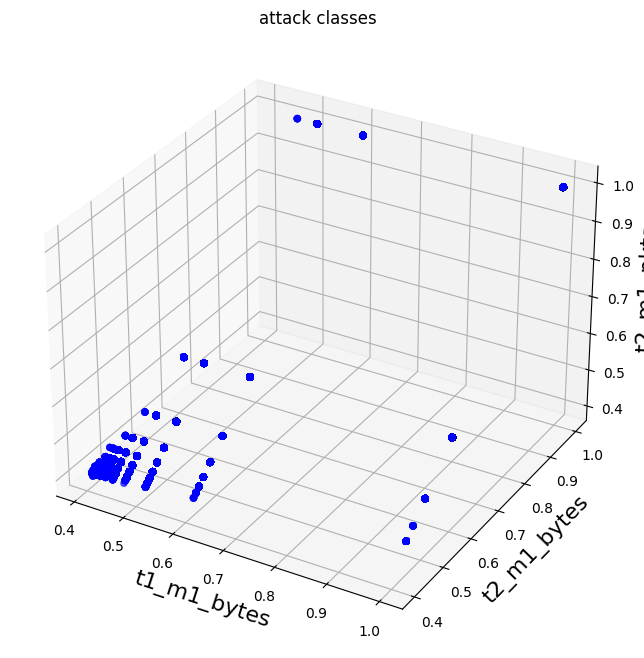

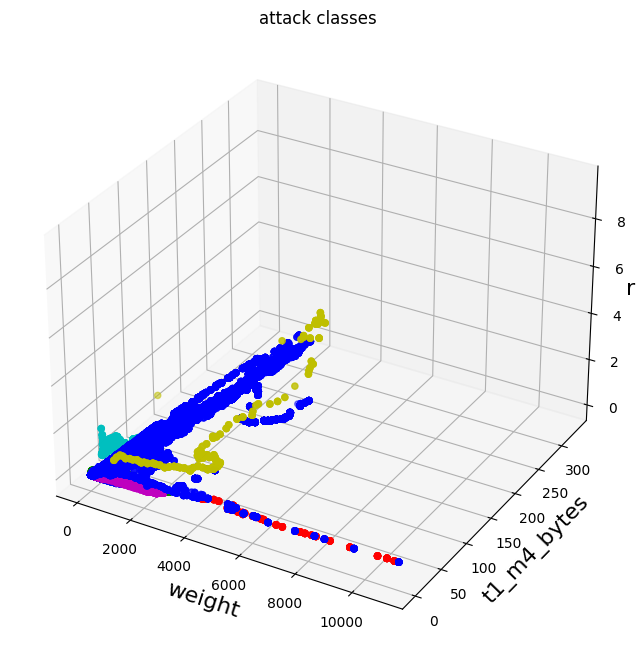

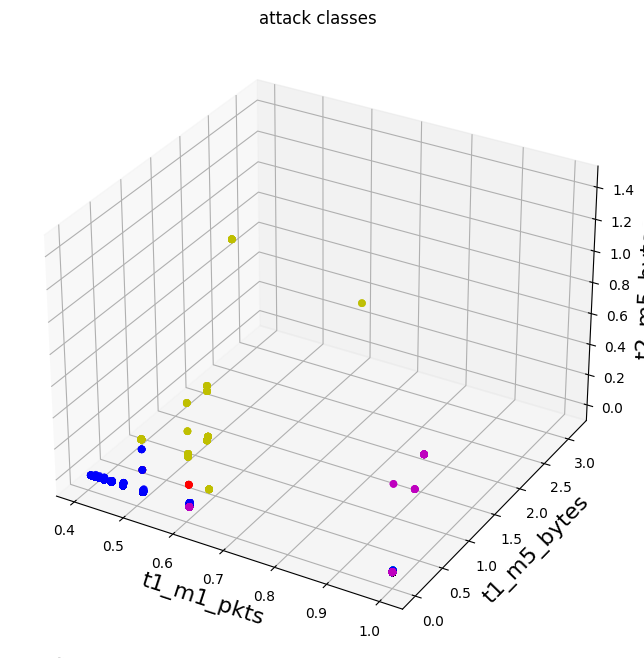

In [23]:
from xgboost import XGBClassifier

clf_m5 = XGBClassifier(tree_method="auto") # gpu_hist
clf_m5=clf_m5.fit(X_train_m5,y_train)
y_pred_m5 = clf_m5.predict(X_test_m5)

clf_smetrics = XGBClassifier(tree_method="auto") # gpu_hist
clf_smetrics=clf_smetrics.fit(X_train_smetrics,y_train)
y_pred_smetrics = clf_smetrics.predict(X_test_smetrics)

clf_smetrics_m5 = XGBClassifier(tree_method="auto") # gpu_hist
clf_smetrics_m5=clf_smetrics_m5.fit(X_train_smetrics_m5,y_train)
y_pred_smetrics_m5 = clf_smetrics_m5.predict(X_test_smetrics_m5)

plot_high_gain_features(clf_m5)
plot_high_gain_features(clf_smetrics)
plot_high_gain_features(clf_smetrics_m5)

In [24]:
import plotly.express as px

def plot_importance(clf, metric = 'all'):
    
    importance = pd.DataFrame()
    importance['Features'] = clf.feature_names_in_
    
    if metric == 'all' or metric == 'gain':
    
        importance['Gain'] = clf.feature_importances_
        importance = importance.sort_values(by=['Gain'],ascending=False)
        fig = px.bar(importance,x='Gain', y='Features',color ='Features',orientation ='h')
        fig.update_yaxes(categoryorder="total ascending")

        fig.show()
    
    if metric == 'all' or metric == 'weight':
        weights = clf.get_booster().get_score(importance_type='weight')
        w = []
        for elm in importance['Features']:
            try:
                w.append(weights[elm])
            except:
                w.append(0)
        importance['Weight'] = w
        importance = importance.sort_values(by=['Weight'],ascending=False)
        fig = px.bar(importance,x='Weight', y='Features',color ='Features',orientation ='h')
        fig.update_yaxes(categoryorder="total ascending")

        fig.show()
    
    if metric == 'all' or metric == 'cover':
        coverages = clf.get_booster().get_score(importance_type='cover')
        c = []
        for elm in importance['Features']:
            try:
                c.append(coverages[elm])
            except:
                c.append(0)
        importance['Coverage'] = c
        importance = importance.sort_values(by=['Coverage'],ascending=False)
        fig = px.bar(importance,x='Coverage', y='Features', color ='Features',orientation ='h')
        fig.update_yaxes(categoryorder="total ascending")

        fig.show()

print("Approach M5")
plot_importance(clf_m5, metric = 'all')
print("Approach Smetrics")
plot_importance(clf_smetrics, metric = 'all')
print("Approach Smetrics + M5")
plot_importance(clf_smetrics_m5, metric = 'all')

Approach M5


Approach Smetrics


Approach Smetrics + M5


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

clf_names = [
    #"Nearest Neighbors",
    #"Decision Tree",
    #"Random Forest",
    #"Bagging",
    #"Extra Trees",
    #"Gradient Boosting",
    "XGBoost",
    #"MLP"#,
    #"Linear SVM",
    #"RBF SVM",
    #"Histogram-based Gradient Boosting"
]

classifiers = [#KNeighborsClassifier(3),
               #DecisionTreeClassifier(),
               #RandomForestClassifier(max_depth=3, random_state=0),
               #BaggingClassifier(n_estimators=10, random_state=0),
               # ExtraTreesClassifier(n_estimators=100, random_state=0),
               # GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
               XGBClassifier(tree_method="auto"),
               # MLPClassifier(alpha=1, max_iter=1000)#,
               #SVC(kernel="linear", C=0.025),
               #SVC(gamma=2, C=1),
               #HistGradientBoostingClassifier()
              ]

In [26]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import numpy as np

def classwise_balanced_accuracy(y_test, pred_target, num_classes):
    class_balanced_accuracy = {}
    
    for cls in range(num_classes):
        true_positive = np.sum((y_test == cls) & (pred_target == cls))
        false_positive = np.sum((y_test != cls) & (pred_target == cls))
        true_negative = np.sum((y_test != cls) & (pred_target != cls))
        false_negative = np.sum((y_test == cls) & (pred_target != cls))
        
        sensitivity = true_positive / (true_positive + false_negative)
        specificity = true_negative / (true_negative + false_positive)
        
        balanced_accuracy = (sensitivity + specificity) / 2
        class_balanced_accuracy[cls] = balanced_accuracy
    
    return class_balanced_accuracy

In [27]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import numpy as np

def classwise_balanced_accuracy(y_test, pred_target, num_classes):
    class_balanced_accuracy = {}
    
    for cls in range(num_classes):
        true_positive = np.sum((y_test == cls) & (pred_target == cls))
        false_positive = np.sum((y_test != cls) & (pred_target == cls))
        true_negative = np.sum((y_test != cls) & (pred_target != cls))
        false_negative = np.sum((y_test == cls) & (pred_target != cls))
        
        sensitivity = true_positive / (true_positive + false_negative)
        specificity = true_negative / (true_negative + false_positive)
        
        balanced_accuracy = (sensitivity + specificity) / 2
        class_balanced_accuracy[cls] = balanced_accuracy
    
    return class_balanced_accuracy

def classwise_mcc(y_test, pred_target, num_classes):
    class_mcc = {}
    
    for cls in range(num_classes):
        true_positive = np.sum((y_test == cls) & (pred_target == cls))
        false_positive = np.sum((y_test != cls) & (pred_target == cls))
        true_negative = np.sum((y_test != cls) & (pred_target != cls))
        false_negative = np.sum((y_test == cls) & (pred_target != cls))
        
        numerator = (true_positive * true_negative) - (false_positive * false_negative)
        denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
        
        # Handling the case when the denominator is zero
        if denominator == 0:
            mcc = 0
        else:
            mcc = numerator / denominator
        
        class_mcc[cls] = mcc
    
    return class_mcc

In [28]:
from pandas import DataFrame
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef, zero_one_loss
from sklearn.metrics import classification_report, confusion_matrix

eval_df=DataFrame(columns=['Classifier',
                           'Precision',
                           'Recall',
                           'TNR',
                           'TPR',
                           'Accuracy',
                           'F1_score',
                           'Balanced_accuracy',
                           'MCC',
                           #'AUROC',
                           #'AUPRC',
                           'Error',
                           'fit_time',
                           'pred_time'])
                           #'Cross_validation_mean'])
cm_df=DataFrame(columns=['Classifier','Confusion_Matrix', 'Classification Report'])

def get_tnr_tpr(y_test, pred_target):
    
    tn=0
    tp=0
    fn=0
    fp=0

    i=0
    y_test_list=list(y_test)
    
    for i in range(len(y_test)):
        if(pred_target[i] == 0):
            if(y_test_list[i] == pred_target[i]):
                tn += 1
            else:
                fn += 1
        else:
            if(y_test_list[i] == pred_target[i]):
                tp += 1
            else:
                fp += 1

    tnr = tn/(tn+fp)
    tpr = tp/(tp+fn)

    return tnr,tpr

def get_auroc(classifier):
    
    y_proba=classifier.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_proba[:, 1])
    return auc(fpr, tpr)

def eval_clf(classifier,y_test,pred_target, fit_time, pred_time, title):
    
    tnr, tpr = get_tnr_tpr(y_test, pred_target) 

    eval_df.loc[len(eval_df.index)] = [type(classifier).__name__.replace('Classifier',''),
                                       precision_score(y_test, pred_target, average='weighted'),
                                       recall_score(y_test, pred_target, average='weighted'),
                                       tnr,
                                       tpr,
                                       accuracy_score(y_test, pred_target),
                                       f1_score(y_test, pred_target, average='weighted'),
                                       balanced_accuracy_score(y_test, pred_target),
                                       matthews_corrcoef(y_test, pred_target),
                                       #get_auroc(classifier),
                                       #average_precision_score(y_test, pred_target),]
                                       zero_one_loss(y_test, pred_target),
                                       fit_time,
                                       pred_time]
                                       #,
                                       #cross_val_score(classifier, X, y, cv=5).mean()]
    cm_df.loc[len(eval_df.index)] = [type(classifier).__name__.replace('Classifier',''),
                                     confusion_matrix(y_test, pred_target),
                                     classification_report(y_test, pred_target)]
    
# df_scores.loc[len(df_scores.index)] = ['DDoS', 2, 'TW (common features except t_features with smetrics)', type(classifier).__name__, classification_report(y_test, pred_target, output_dict=True).get('2')['f1-score'], 6]
    # df_scores.loc[len(df_scores.index)] = ['ScanService', 4, 'TW (common features except t_features with smetrics)', type(classifier).__name__, classification_report(y_test, pred_target, output_dict=True).get('4')['f1-score'], 6]
    # df_scores.loc[len(df_scores.index)] = ['OS Fingerprint', 1, 'TW (common features except t_features with smetrics)', type(classifier).__name__, classification_report(y_test, pred_target, output_dict=True).get('1')['f1-score'], 6]
    
    num_classes = len(np.unique(y_test))  # Assuming labels start from 0 and are continuous
    class_balanced_accuracies = classwise_balanced_accuracy(y_test, pred_target, num_classes)
    class_mcc = classwise_mcc(y_test, pred_target, num_classes)
    print(class_balanced_accuracies)
    
    # approach_name = 'TW (common features except t_features with smetrics)'
    # priority = 6
    df_scores.loc[len(df_scores.index)] = ['Scanning',
                                           1,
                                           approach_name,
                                           type(classifier).__name__, 
                                           classification_report(y_test, pred_target, output_dict=True).get('1')['f1-score'],
                                           class_balanced_accuracies.get(1, "Class not found"),
                                           class_mcc.get(1, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('1')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('1')['recall'],
                                           priority]
    df_scores.loc[len(df_scores.index)] = ['DoS',
                                           2,
                                           approach_name,
                                           type(classifier).__name__,
                                           classification_report(y_test, pred_target, output_dict=True).get('2')['f1-score'],
                                           class_balanced_accuracies.get(2, "Class not found"),
                                           class_mcc.get(2, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('2')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('2')['recall'],
                                           priority]
    df_scores.loc[len(df_scores.index)] = ['DDoS',
                                           3,
                                           approach_name,
                                           type(classifier).__name__,
                                           classification_report(y_test, pred_target, output_dict=True).get('3')['f1-score'],
                                           class_balanced_accuracies.get(3, "Class not found"),
                                           class_mcc.get(3, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('3')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('3')['recall'],
                                           priority]
    df_scores.loc[len(df_scores.index)] = ['Ransomware',
                                           4,
                                           approach_name,
                                           type(classifier).__name__,
                                           classification_report(y_test, pred_target, output_dict=True).get('4')['f1-score'],
                                           class_balanced_accuracies.get(4, "Class not found"),
                                           class_mcc.get(4, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('4')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('4')['recall'],
                                           priority]
    df_scores.loc[len(df_scores.index)] = ['Injection',
                                           5,
                                           approach_name,
                                           type(classifier).__name__,
                                           classification_report(y_test, pred_target, output_dict=True).get('5')['f1-score'],
                                           class_balanced_accuracies.get(5, "Class not found"),
                                           class_mcc.get(5, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('5')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('5')['recall'],
                                           priority]
    df_scores.loc[len(df_scores.index)] = ['Password',
                                           6,
                                           approach_name,
                                           type(classifier).__name__,
                                           classification_report(y_test, pred_target, output_dict=True).get('6')['f1-score'],
                                           class_balanced_accuracies.get(6, "Class not found"),
                                           class_mcc.get(6, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('6')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('6')['recall'],
                                           priority]
    df_scores.loc[len(df_scores.index)] = ['XSS',
                                           7,
                                           approach_name,
                                           type(classifier).__name__,
                                           classification_report(y_test, pred_target, output_dict=True).get('7')['f1-score'],
                                           class_balanced_accuracies.get(7, "Class not found"),
                                           class_mcc.get(7, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('7')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('7')['recall'],
                                           priority]
    df_scores.loc[len(df_scores.index)] = ['Backdoor',
                                           8,
                                           approach_name,
                                           type(classifier).__name__,
                                           classification_report(y_test, pred_target, output_dict=True).get('8')['f1-score'],
                                           class_balanced_accuracies.get(8, "Class not found"),
                                           class_mcc.get(8, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('8')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('8')['recall'],
                                           priority]
    df_scores.loc[len(df_scores.index)] = ['MitM',
                                           9,
                                           approach_name,
                                           type(classifier).__name__,
                                           classification_report(y_test, pred_target, output_dict=True).get('9')['f1-score'],
                                           class_balanced_accuracies.get(9, "Class not found"),
                                           class_mcc.get(9, "Class not found"),
                                           classification_report(y_test, pred_target, output_dict=True).get('9')['precision'],
                                           classification_report(y_test, pred_target, output_dict=True).get('9')['recall'],
                                           priority]
    
    if verbose:
        print(eval_df.columns)
        print(eval_df.loc[eval_df.Classifier==type(classifier).__name__.replace('Classifier','')])
        
def show_eval():
    print(eval_df)
    if very_verbose:
        for entry in cm_df.iterrows():
            print("Learning report for "+str(entry[0])+":")
            print(entry[1])
            #print(entry[2])

In [29]:
def store_eval(eval_type):
    os.chdir('/kaggle/working/')
    os.makedirs('eval/', exist_ok=True)
    eval_df.to_csv('eval/output_'+eval_type, index=False)
    cm_df.to_csv('eval/output_'+eval_type+'_report', index=False)

In [30]:
from datetime import datetime

if eval_ML:
    for clf in classifiers:
        print('Evaluating: ' + type(clf).__name__.replace('Classifier',''))
        print(datetime.now())
        start_time =   datetime.now()
        clf=clf.fit(X_train_m5,y_train)
        fit_time =  datetime.now() - start_time
        y_pred = clf.predict(X_test_m5)
        pred_time =  datetime.now() - start_time - fit_time
        eval_clf(clf,y_test,y_pred, fit_time, pred_time, "Approach M5")
    store_eval('numeric_only_m5')
     
    for clf in classifiers:
        print('Evaluating: ' + type(clf).__name__.replace('Classifier',''))
        print(datetime.now())
        start_time =   datetime.now()
        clf=clf.fit(X_train_smetrics,y_train)
        fit_time =  datetime.now() - start_time
        y_pred = clf.predict(X_test_smetrics)
        pred_time =  datetime.now() - start_time - fit_time
        eval_clf(clf,y_test,y_pred, fit_time, pred_time, "Approach Smetrics")
    store_eval('numeric_only_smetrics')

    for clf in classifiers:
        print('Evaluating: ' + type(clf).__name__.replace('Classifier',''))
        print(datetime.now())
        start_time =   datetime.now()
        clf=clf.fit(X_train_smetrics_m5,y_train)
        fit_time =  datetime.now() - start_time
        y_pred = clf.predict(X_test_smetrics_m5)
        pred_time =  datetime.now() - start_time - fit_time
        eval_clf(clf,y_test,y_pred, fit_time, pred_time, "Approach Smetrics + M5")
    store_eval('numeric_only_smetrics_m5')
        

Evaluating: XGB
2025-01-29 01:30:55.794852
{0: 0.9944361464397742, 1: 1.0, 2: 1.0, 3: 0.9999846070961287, 4: 0.9983945833688053, 5: 0.9839390493677695, 6: 0.9814618806417565, 7: 0.9782608695652174, 8: 0.9993321460373998, 9: 0.9776119402985075}


NameError: name 'approach_name' is not defined

In [ ]:
if verbose:
    show_eval()

In [ ]:
import plotly.express as px
import re

def plot_evals(results_path, metrics = ["TNR", "TPR", "Precision", "Recall", "F1_score", "Accuracy", "Balanced_accuracy", "MCC"]):
    eval_df = pd.read_csv(results_path)
    # ordering columns
    col_order = ["Classifier"] + metrics
    eval_df = eval_df[col_order]
    # Melt the dataframe to convert the metrics into a single column
    melted_df = pd.melt(eval_df, id_vars=['Classifier'], var_name='Metric', value_name='Value')

    # selecting only the desired metrics
    melted_df = melted_df[melted_df['Metric'].isin(metrics)]

    # Create the bar chart
    fig = px.bar(melted_df, x='Classifier', y='Value', color='Metric', barmode='group', hover_data={"Metric":True,
                                                                                                    "Classifier":False,
                                                                                                    "Value":True})
    
    # Update the layout
    fig.update_layout(title='Evaluation Metrics by Classifier',
                    xaxis_title='Classifier',
                    yaxis_title='Value',
                    hovermode='x unified',
                )

    # Show the chart
    fig.show()
    
    
def plot_fit_pred_time(results_path):
    eval_df = pd.read_csv(results_path)
    
    # Melt the dataframe to convert the metrics into a single column
    melted_df = pd.melt(eval_df[["Classifier", "fit_time", "pred_time"]], id_vars=['Classifier'], var_name='Time', value_name='Value')
    melted_df["Value"] = pd.to_timedelta(melted_df["Value"])
    melted_df['Value'] = melted_df['Value'].dt.total_seconds()
    fig = px.bar(melted_df, x="Classifier", y="Value", color='Time', barmode='group', hover_data={"Time":True,
                                                                                                "Classifier":False,
                                                                                                "Value":True})
    # Update the layout
    fig.update_layout(title='Training and prediction time by Classifier',
                     xaxis_title='Classifier',
                     yaxis_title='Time in seconds',
                     hovermode='x unified')
    fig.update_traces(hovertemplate='%{y:.2f}s')
    
    fig.show()
    

def plot_confusion_matrixes(results_report_path):
    df = pd.read_csv(results_report_path)
    print(df)
    for row in df.itertuples():
        matrix = row.Confusion_Matrix
        
        # erasing the starting spaces at the beginning of a bracket
        matrix = re.sub(r"\[\s+", "[", matrix)

        # replace the spaces between closing and opening bracket by a comma
        matrix = re.sub(r"]\s+\[", "],[", matrix)  
        
        # replace all series of spaces by a comma
        matrix = re.sub(r"\s+", ",", matrix)

        # convert the string to a numpy array
        confusion_matrix = np.array(eval(matrix))

        # in case of imbalanced data, search for the nth highest value in the confusion matrix to be the highest scale
        n=2
        nth_max = confusion_matrix.flatten()
        nth_max.sort()
        nth_max = nth_max[-n]
        fig = px.imshow(confusion_matrix, height=800,
                width=800,
                text_auto=True,
                title=f"{row.Classifier}: Confusion matrix",
                color_continuous_scale='Blues',
                range_color=[0, nth_max]) # to use with Y = attack_cat
        fig.update_layout(xaxis_title="Predicted label",
                    yaxis_title="True label")

        fig.show()

In [ ]:
print("Approach M5")
plot_evals('/kaggle/working/eval/output_numeric_only_m5')
plot_fit_pred_time('/kaggle/working/eval/output_numeric_only_m5')
print("Approach Smetrics")
plot_evals('/kaggle/working/eval/output_numeric_only_smetrics')
plot_fit_pred_time('/kaggle/working/eval/output_numeric_only_smetrics')
print("Approach Smetrics + M5")
plot_evals('/kaggle/working/eval/output_numeric_only_smetrics_m5')
plot_fit_pred_time('/kaggle/working/eval/output_numeric_only_smetrics_m5')

In [ ]:
counts = df_topredict['type'].value_counts()

print(counts)

map_dict= {
    'normal': 0,
    'scanning': 1,
    'dos': 2,
    'ddos': 3,
    'ransomware': 4,
    'injection': 5,
    'password': 6,
    'xss': 7,
    'backdoor':8,
    'mitm':9
    
}

# Swap the keys and values in the map_dict
reverse_map_dict = {v: k for k, v in map_dict.items()}

# Map the numeric labels to their string labels
mapped_labels = {reverse_map_dict[key]: value for key, value in counts.items()}

print(mapped_labels)

In [ ]:
print("Approach M5")
plot_confusion_matrixes("eval/output_numeric_only_m5_report")
print("Approach Smetrics")
plot_confusion_matrixes("eval/output_numeric_only_smetrics_report")
print("Approach Smetrics + M5")
plot_confusion_matrixes("eval/output_numeric_only_smetrics_m5_report")

In [ ]:
print(df_scores)

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Define groups based on the approach names
group_labels = df_scores["approach_name"].unique()
metrics = ["f1_score", "balanced_accuracy", "MCC"]

# Create traces for each metric group
fig = go.Figure()

for approach in group_labels:
    filtered_df = df_scores[df_scores["approach_name"] == approach]
    for metric in metrics:
        fig.add_trace(go.Scatter(
            x=filtered_df["attack_type"],
            y=filtered_df[metric],
            mode='lines+markers+text',
            text=[f'{val:.4f}' for val in filtered_df[metric]],
            textposition='top center',
            name=f"{approach}_{metric}"
        ))

# Customize the layout
fig.update_layout(
    title='Comparison of Different Feature Metrics Across Approaches',
    xaxis_title='Attack Type',
    yaxis_title='Score',
    legend_title='Metrics',
    template='plotly_white'
)

# Show the plot
fig.show()
